In [1]:
!pip install -q scikit-image scipy

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import Dataset
import torch
import numpy as np, cv2, math, random, os, glob, csv
import matplotlib.pyplot as plt
from PIL import Image
from skimage.morphology import skeletonize
from scipy.optimize import curve_fit
from scipy.ndimage import median_filter
from skimage.morphology import skeletonize
from google.colab import files
from tqdm import tqdm
from sklearn.linear_model import RANSACRegressor, LinearRegression
from sklearn.base import BaseEstimator, RegressorMixin
from numba import njit
from skimage.morphology import skeletonize

In [3]:
!unzip new_data.zip

Archive:  new_data.zip
   creating: new_data/
  inflating: new_data/image_0038.bmp  


In [4]:
class CurveDataset(Dataset):
    def __init__(self, img_dir, mask_dir=None, transform=None):
        self.imgs = sorted(glob.glob(os.path.join(img_dir, '*.bmp')))
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        img = Image.open(img_path).convert('RGB')
        img = np.array(img)

        if self.transform:
            img = self.transform(image=img)['image']
        return img

In [5]:
ds = CurveDataset("/content/new_data")

100%|██████████| 159/159 [00:10<00:00, 14.96it/s]


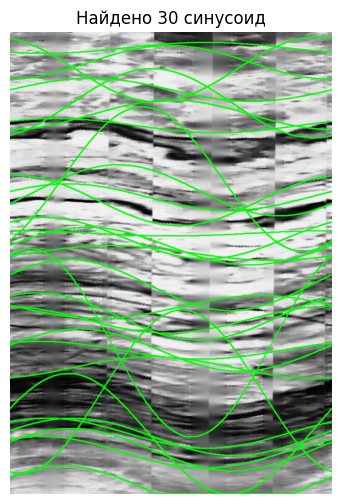

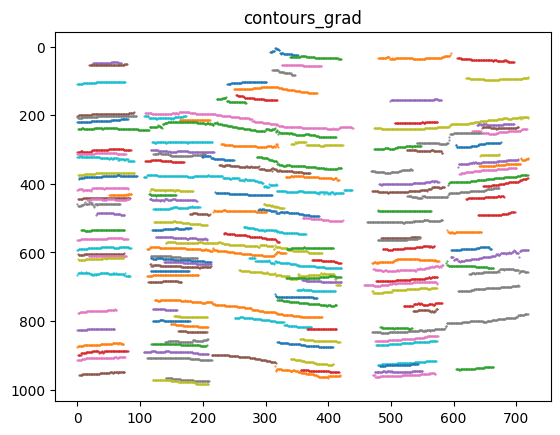

In [58]:
ω = None

def fit_sinusoid_fast(points, ω, max_pts=2000, min_samples=0.3, residual_threshold=5.0, max_trials=2000, random_state=0):
    points = np.asarray(points)
    xs, ys = points[:, 0], points[:, 1]

    if len(xs) > max_pts:
        sel = np.random.choice(len(xs), max_pts, replace=False)
        xs, ys = xs[sel], ys[sel]

    order = np.argsort(xs)
    xs, ys = xs[order], ys[order]
    ys = median_filter(ys, size=5)

    X = np.column_stack([np.sin(ω * xs), np.cos(ω * xs)])
    base = LinearRegression(fit_intercept=True)
    try:
        ransac = RANSACRegressor(
            estimator=base,
            min_samples=min_samples,
            residual_threshold=residual_threshold,
            max_trials=max_trials,
            random_state=random_state,
        )
    except TypeError:
        ransac = RANSACRegressor(
            base_estimator=base,
            min_samples=min_samples,
            residual_threshold=residual_threshold,
            max_trials=max_trials,
            random_state=random_state,
        )

    try:
        ransac.fit(X, ys)
        a, b = ransac.estimator_.coef_
        y0 = ransac.estimator_.intercept_
        A = float(np.hypot(a, b))
        θ  = float(np.arctan2(b, a))
        if A < 0:
            A = -A
            θ = (θ + math.pi) % (2 * math.pi)
        return A, θ, y0
    except Exception:
        return None

def inpaint_image(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    mask = (gray == 0).astype(np.uint8) * 255
    inpainted = cv2.inpaint(gray, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
    return cv2.cvtColor(inpainted, cv2.COLOR_GRAY2RGB)

def gradient_edges(gray):
    #в целом оба эти оператора показывают хорошие результаты
    #grad_x = cv2.Scharr(gray, cv2.CV_64F, 0, 1, scale=1)
    #grad_y = cv2.Scharr(gray, cv2.CV_64F, 1, 0, scale=1)
    # ksize=3 или ksize=5 в обоих случах хорошие результаты
    grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
    grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)
    magnitude = cv2.magnitude(grad_x, grad_y)
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    _, binary = cv2.threshold(magnitude, 40, 255, cv2.THRESH_BINARY)
    return binary

def centerlines_from_grad(mask_bin, min_x_span=50, min_points=80):
    sk = skeletonize((mask_bin > 0)).astype(np.uint8) * 255

    num, labels = cv2.connectedComponents(sk)
    curves = []
    for lab in range(1, num):
        ys, xs = np.where(labels == lab)
        if xs.size < min_points:
            continue
        if np.ptp(xs) < min_x_span:
            continue

        by_x = {}
        for x, y in zip(xs, ys):
            by_x.setdefault(x, []).append(y)

        xs_sorted = sorted(by_x.keys())
        pts = np.array([[x, int(np.median(by_x[x]))] for x in xs_sorted], dtype=np.int32)
        curves.append(pts)

    return curves

def detect_and_draw(img_rgb,
                    background="rgb",
                    top_N=30,
                    min_len=40):

    h, w = img_rgb.shape[:2]
    ω = 2 * np.pi / w

    gray_crop = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    grad_mask = gradient_edges(gray_crop)
    contours_grad = centerlines_from_grad(grad_mask, min_x_span=30, min_points=60)

    scored = []
    for pts in tqdm(contours_grad):
            fit = fit_sinusoid_fast(pts, ω, h)
            if fit is None:
                continue
            A, θ, y0 = fit

            xs, ys = pts[:, 0], pts[:, 1]
            rmse = np.sqrt(((ys - (A*np.sin(ω*xs + θ) + y0)) ** 2).mean())
            if rmse > 1:
                continue

            scored.append((rmse, A, θ, y0))

    scored.sort(key=lambda t: t[0], reverse=True)
    curves = [(A, θ, y0) for _, A, θ, y0 in scored[:top_N]]

    if background == "rgb":
        canvas = img_rgb.copy()
    else:
        canvas = cv2.cvtColor(grad_mask, cv2.COLOR_GRAY2BGR)

    xs_full = np.arange(w)
    for A, θ, y0 in curves:
        ys = (A * np.sin(ω * xs_full + θ) + y0).astype(int)
        good = (ys >= 0) & (ys < h)
        pts = np.column_stack([xs_full[good], ys[good]]).astype(np.int32)
        cv2.polylines(canvas, [pts], False, (0, 255, 0), 2)

    plt.figure(figsize=(8, 6))
    plt.imshow(canvas)
    plt.axis("off")
    plt.title(f"Найдено {len(curves)} синусоид")
    plt.show()

    for c in contours_grad:
        plt.plot(c[:, 0], c[:, 1], '.', markersize=1)
    plt.gca().invert_yaxis()
    plt.title("contours_grad")

sample_path = ds.imgs[0]
img = np.array(Image.open(sample_path).convert('RGB'))
img = inpaint_image(img)

detect_and_draw(img_rgb=img)

In [46]:
img.shape

(1035, 720, 3)

In [47]:
model_csv = "/content/forest_model.pkl"

In [48]:
import joblib

saved = joblib.load(model_csv)
clf = saved['model']
scaler = saved['scaler']

In [49]:
IMG_PATH = "/content/5.bmp"

In [59]:
img = np.array(Image.open(IMG_PATH).convert("RGB"))
h, w = img.shape[:2]
ω = 2 * math.pi / w

up, down = 552, 555
PIX2MM = (down - up) / h * 1000

def process_image_by_tiles(img_rgb, up, down, step=256, stride=128, rmse_thr=1.0, top_N=20):
    h, w = img_rgb.shape[:2]
    ω = 2 * np.pi / w
    PIX2MM = (down - up) / h * 1000

    xs_full = np.arange(w)
    rows, rows_for_pred = [], []

    canvas = img_rgb.copy()

    for top in tqdm(range(0, h, stride)):
        bottom = min(h, top + step)
        crop = img_rgb[top:bottom]
        crop_h = crop.shape[0]

        gray_crop = cv2.cvtColor(crop, cv2.COLOR_RGB2GRAY)
        grad_mask = gradient_edges(gray_crop)
        curves = centerlines_from_grad(grad_mask, min_x_span=30, min_points=60)

        scored = []
        for pts in curves:
            fit = fit_sinusoid_fast(pts, ω, crop_h)
            if fit is None:
                continue
            A_px, θ, y0 = fit
            xs, ys = pts[:, 0], pts[:, 1]
            rmse = np.sqrt(((ys - (A_px * np.sin(ω * xs + θ) + y0)) ** 2).mean())
            if rmse > rmse_thr:
                continue

            scored.append((rmse, A_px, θ, y0))

        scored.sort(reverse=True, key=lambda t: t[0])
        selected = scored[:top_N]

        for rmse, A_px, θ, y0 in selected:
            y0_global = y0 + top
            A_mm = A_px * PIX2MM
            depth_m = up + (down - up) * (y0_global / h)

            rows.append([depth_m, A_mm, θ])
            rows_for_pred.append([depth_m, A_mm, θ, A_px, y0_global])

            ys_full = (A_px * np.sin(ω * xs_full + θ) + y0_global).astype(int)
            good = (ys_full >= 0) & (ys_full < h)
            pts_vis = np.column_stack([xs_full[good], ys_full[good]]).astype(np.int32)
            cv2.polylines(canvas, [pts_vis], False, (0, 255, 0), 2)

    return rows_for_pred

In [60]:
img = inpaint_image(img)
df_result = process_image_by_tiles(img, up, down, step=256, stride=128, top_N=20)

100%|██████████| 9/9 [00:32<00:00,  3.62s/it]


In [61]:
csv_path = "/content/result.csv"

df_result = pd.DataFrame(
    df_result,
    columns=["depth_m", "A_mm", "theta_rad", "A_px", "y0_global"]
)
X_pred_scaled = scaler.transform(df_result[["depth_m", "A_mm", "theta_rad"]])
y_pred = clf.predict(X_pred_scaled)

filtered = df_result[y_pred == 1][["depth_m", "A_mm", "theta_rad"]]

In [62]:
filtered["depth_rounded"] = filtered["depth_m"]

filtered_unique = (
    filtered.sort_values("A_mm", ascending=False)
    .drop_duplicates(subset="depth_rounded")
    .drop(columns="depth_rounded")
    .sort_values("depth_m")
)

rows_list = filtered_unique[["depth_m", "A_mm", "theta_rad"]].values.tolist()
rows_list.sort(key=lambda x: x[0])

THRESHOLD = 0.01
averaged_rows = []

i = 0
while i < len(rows_list) - 1:
    d1 = rows_list[i][0]
    d2 = rows_list[i+1][0]

    if abs(d2 - d1) <= THRESHOLD:
        A_mm, theta = rows_list[i+1][1], rows_list[i+1][2]
        depth_avg = (d1 + d2) / 2
        averaged_rows.append([depth_avg, A_mm, theta])

    i += 1

df_avg = pd.DataFrame(averaged_rows, columns=["depth_m", "A_mm", "theta_rad"])
df_avg.to_csv(csv_path, index=False)

In [63]:
len(df_avg)

8

In [64]:
df = pd.read_csv("/content/result.csv")

In [65]:
df

,depth_m,A_mm,theta_rad
0,552.685113,102.316588,-2.192580
1,553.642604,73.168481,-2.333843
2,553.677932,73.098987,-2.678512
3,553.684300,76.823145,-2.682719
4,554.022897,43.253979,-2.424583
5,554.598271,92.254585,-2.501965
6,554.695674,65.907975,-2.679488
7,554.698591,47.149587,-2.336648


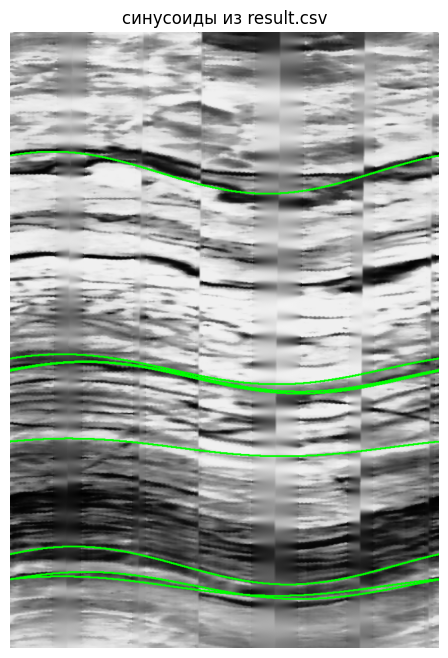

In [66]:
def draw_curves_from_csv(img_rgb, csv_path, up=552, down=555, color=(0, 255, 0), thickness=2):
    h, w = img_rgb.shape[:2]
    ω = 2 * math.pi / w
    PIX2MM = (down - up) / h * 1000

    df = pd.read_csv(csv_path)
    canvas = img_rgb.copy()
    xs_full = np.arange(w)

    for _, row in df.iterrows():
        depth_m, A_mm, theta = row["depth_m"], row["A_mm"], row["theta_rad"]

        y0 = h * (depth_m - up) / (down - up)
        A_px = A_mm / PIX2MM

        ys = (A_px * np.sin(ω * xs_full + theta) + y0).astype(int)
        valid = (ys >= 0) & (ys < h)
        pts = np.column_stack([xs_full[valid], ys[valid]]).astype(np.int32)

        if len(pts) > 1:
            cv2.polylines(canvas, [pts], False, color, thickness)

    plt.figure(figsize=(10, 8))
    plt.imshow(canvas)
    plt.axis("off")
    plt.title("синусоиды из result.csv")
    plt.show()

    return canvas

canvas = draw_curves_from_csv(img, csv_path="/content/result.csv")
